# EDA

## Goal

Predicting the start of serves in a volleyball match.  The input data will be a video of the volleyball match.    The output will be a time series of predictions: 1. if a serve is in play, for a given time interval 2. which team is serving.

Use the output to enrich the video with cue points, running game score, and exciting rally plays.

A web app will be used to present the results.  It will have an embedded widget to watch the match.  Below the video will be a table with following columns.  A column of hyperlinks for that cue the video to start of a serve for the next point.  A column with match score.  A column to indictate exciting rally play.  The table could also be replaced with a graphic.  The graphic could be a timeseries of excitement level; plus vertical marks to indicate when service starts for each point. (edited) 

## Approach

Explore audio signal to discover if there are any obvious signals that could be used to train a model. 

Explore video signale to do similar feature extraction, ball motion / lack of motion 

In [6]:
! pip install scipy


     |████████████████████████████████| 55.6 MB 3.2 MB/s            
You should consider upgrading via the '/Users/alex/Library/PythonVEnvs/vball/bin/python3.9 -m pip install --upgrade pip' command.


In [7]:
pip install numpy


You should consider upgrading via the '/Users/alex/Library/PythonVEnvs/vball/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install pydub

You should consider upgrading via the '/Users/alex/Library/PythonVEnvs/vball/bin/python3.9 -m pip install --upgrade pip' command.






## Audio from video

In [ ]:
src = "assests/5U5A9273.mp3"
dst = "5U5A9273.wav"

In [13]:
from os import path
from pydub import AudioSegment

# sound = AudioSegment.from_mp3(src)
# sound.export(dst, format="wav")

<_io.BufferedRandom name='5U5A9273.wav'>

## Analyze Whistle Spectrograph

Here we compare the Waveform vs Spectrograph view of audio in file 5U5A9273.wav,looking for features we can extract.


![alt text](assets/first-wave.jpg "Whistle 3s from start, .7s long; hard to discriminate vs similar form at beginning")

This whistle generates frequencies between 3000-5000 Hz. 
There are 2 distinct streaks in the Audacity image.  If we can extract this spectrograph and use it as features, maybe we can train a model to detect the whistle.


![alt text](assets/first-spectro.jpg "Whistle 3s from start, .7s long")

In [930]:
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack as fftpk
import numpy as np
from matplotlib import pyplot as plt

s_rate, signal = wavfile.read("5U5A9273.wav") 

In [931]:
# Inspect the sample rate
s_rate

44100

In [8]:
!pip install matplotlib

     |████████████████████████████████| 7.3 MB 1.9 MB/s            
     |████████████████████████████████| 65 kB 5.7 MB/s             
     |████████████████████████████████| 944 kB 1.9 MB/s            
You should consider upgrading via the '/Users/alex/Library/PythonVEnvs/vball/bin/python3.9 -m pip install --upgrade pip' command.







Use a different package to save audio in mp3 format, wav is too big.  Hopefully, we don't impact the whistle sound during the compression.

In [1]:
import moviepy.editor as mp


b = mp.VideoFileClip("5U5A9273.MOV")
b.audio.write_audiofile(r"5U5A9273.mp3")

In [932]:
len(signal)

16443567

In [17]:
signal

array([[2861, 2861],
       [5008, 5008],
       [6148, 6148],
       ...,
       [-947, -947],
       [-867, -867],
       [-621, -621]], dtype=int16)

The signal array above is 2 channel 16 bit.

Return a clip of **signal**.  Here s_rate and signal are globals... not the best example of coding but it works

In [933]:
import math

def clip(start_secs,end_secs):
    """
    Return a clip of signal.  Here s_rate and signal are globals... not the best example
    """
    start_sec = start_secs # 2.9
    end_sec = end_secs #.2
    start = math.floor(s_rate*start_sec)

    end = math.floor(start + s_rate*end_sec)

    clip = signal[np.s_[start:end]]
    return clip

Function to generate and plot the fft of clip using scipy and matplotlib

In [959]:
import scipy.io.wavfile as wavfile
import scipy.fft as fft
import scipy.fftpack as fftpk
import numpy as np
from matplotlib import pyplot as plt 

def plot(clip):
    FFT = abs(fft.fft(clip))#,norm='forward'))
    freqs = fftpk.fftfreq(len(FFT), (1.0/s_rate))

    plt.plot(freqs[range(len(FFT)//2)], FFT[range(len(FFT)//2)])                                                          
    plt.xlabel('Log(Frequency (Hz))')
    plt.ylabel('Log(Amplitude)')
    plt.xscale('log')

    plt.yscale('log')

    print (plt.ylim())
    plt.ylim(10,40000)

    plt.xlim(1000,10000)

    plt.show()

In [ ]:
np.amax(freqs)

In [188]:
len(freqs)

30870

## FFT analysis 
The following graphs show FFT of the audio.  Hoping to determing if the FFT could be a candidate featureset.  Exploring different instant in time, as well as length of audio clip.


Graph 1 is for positive example starting at 3 seconds, and 0.1 seconds long *clip(3,0.1)*. A whistle is being blown.  Nothing obvious stands out.  There are a few humps between 1K - 10K; with peaks at 2K, 4K, 6.5K, 9K.  

(2.5195649937564566, 65687.52955773045)


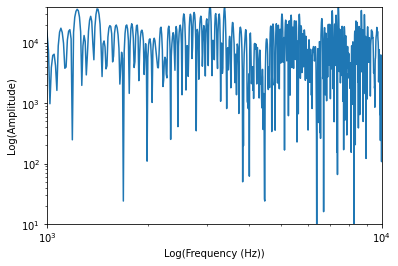

In [960]:
plot(clip(3,0.1))


Graph 2 is for positive example.  Nothing obvious stands out.  There are a fewer humps vs. Graph 1.  

(12.247376476290176, 58491.22066156909)


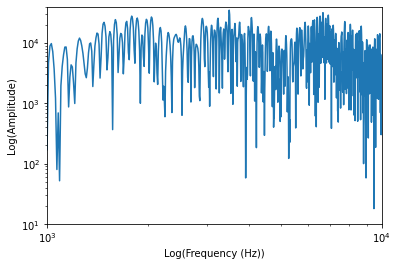

In [961]:
plot(clip(3.1,0.1))

Graph 3, positive,  starts a bit earlier at 2.9 seconds, and for 0.3 seconds long.  Now we are starting to see 3 humps at 1K, just under 3K, and just over 4K Hertz.

(2.5195649937564566, 65687.52955773045)


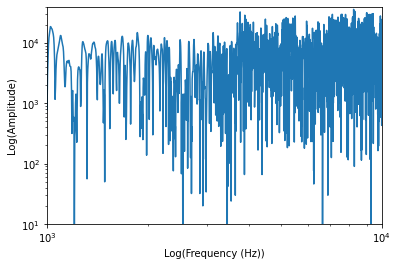

In [962]:
plot(clip(2.9,0.3))

Graph 4, negative example below starts earlier again and for shorter time.  No visible features, and there shouldn't be during this timerange if you look at the original spectrograph above.  It does look very different than positive examples.

(1.2672831883755604, 28994.308720452205)


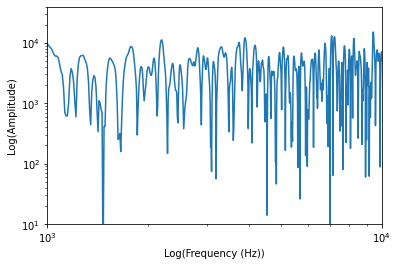

In [963]:
plot(clip(2.7,0.1))

Graph 5, negative example looks similar to Graph 4.  

(3.9687672577987994, 35282.49224613486)


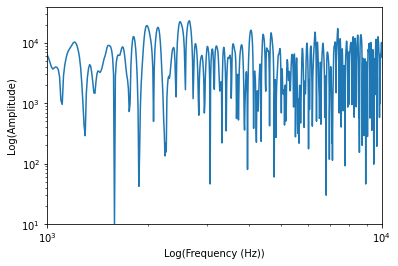

In [964]:
plot(clip(2.8,0.1))

Graph 6, positive example.  Looks different than negative example.  But nothing pops out.  Not looking so good.

(5.253659935005685, 54736.69852209199)


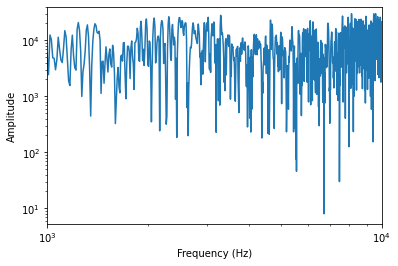

In [206]:
plot(clip(2.93,.1))

Graph 7, positive

(1.2192776805506056, 65238.62551480416)


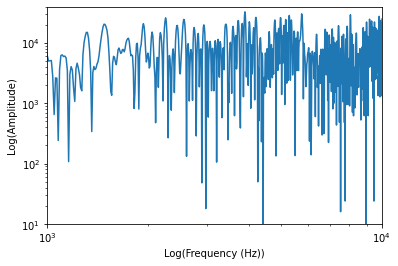

In [967]:
plot(clip(3.02,0.1))

(12.247376476290176, 58491.22066156909)


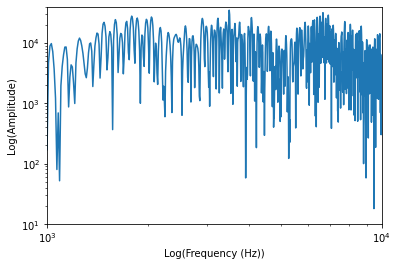

In [968]:
#Graph 8, positive
plot(clip(3.1,0.1))

(1.2294009880516767, 54839.71515822961)


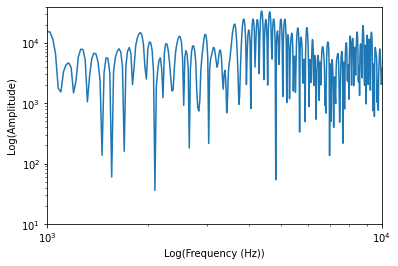

In [969]:
#Graph 9, positive
plot(clip(3.2,0.05))

(2.6078511772396906, 31869.916782586803)


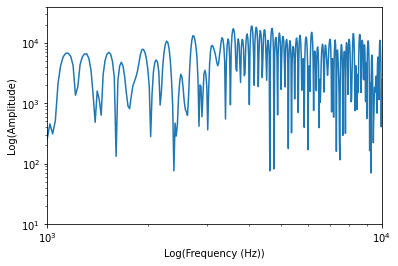

In [971]:
#Graph 10, positive
plot(clip(3.3,0.051))

(2.589186231375911, 37058.74797156268)


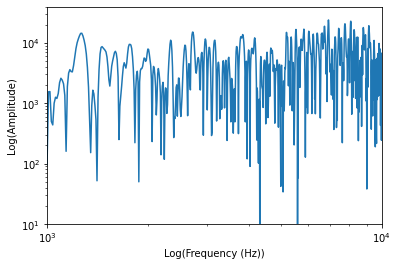

In [973]:
#Graph 11, positive but whistle is coming to an end
plot(clip(3.4,0.1))

### Spectro 2
Whistle at 30.4 seconds.  Does it show similar characterstics as the whistle at 3s?  I think so.
<br>
<img src="project/assets/second-spectro.jpg" alt="Whistle 30s from start, .7s long; looks similar to Spectro 1" style="width:350px;"/>

(1.2939488739470768, 18724.07827528348)


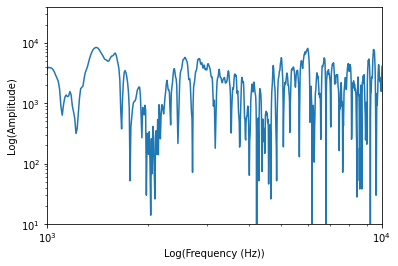

In [978]:
#
# Graph 12, positive, Here we look at another whistle in the audio ~ 30.3 s.  Does it show similar characterstics as the whistle at 3s?
#
plot(clip(30.3,0.1))

(1.2586305492827963, 33480.83361238335)


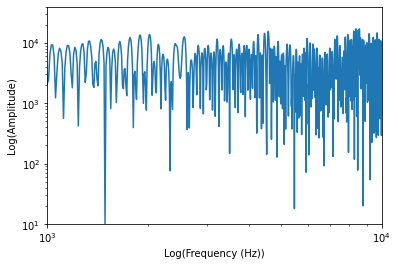

In [979]:
#
# Graph 13, positive, Here we look at another whistle in the audio ~ 30.4 s. 
#
plot(clip(30.4,0.1))

(3.917014429617388, 46480.29852108148)


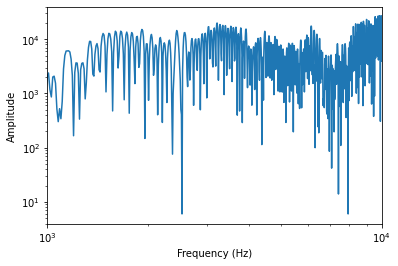

In [217]:
#
# Graph 14, positive, humps are showing up again
#
plot(clip(30.5,0.1))

(1.2333767772418383, 51244.681403310606)


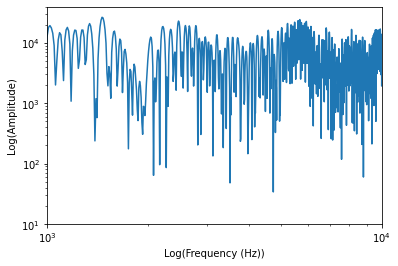

In [980]:
#
# Graph 15, positive, more humps
#
plot(clip(30.6,0.1))

(1.235884410215904, 49104.915879146)


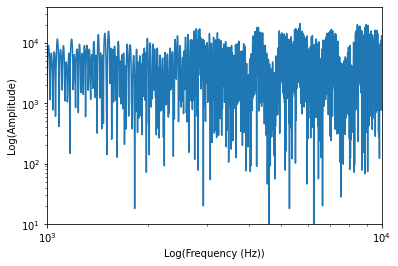

In [982]:
#
# Graph 16, positive,  humps keep increasing
#

plot(clip(30.4,0.3))

(1.2370817209332288, 48116.46554368)


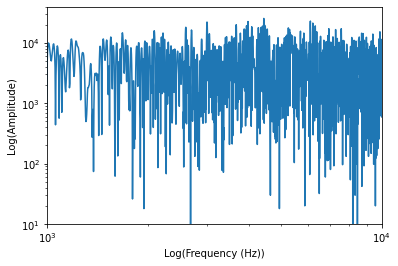

In [983]:
#
# Graph 17, negative, whistle is ends 
#
plot(clip(30.8,0.3))

In [223]:
np.amax(freqs)

22048.571428571424

In [240]:
for i in range(0,len(freqs)):
    if freqs[i] > 20000:
        #print(f'{i},{freqs[i]}')

IndentationError: expected an indented block (12609169.py, line 3)

In the graphs above it doesn't look like there is an obvious signal that stands out.  Its not looking promising.

Taking a look at the spectrum library.  Which can calcuate the signal power instead of amplitude.  Also looking at a wider range of frequencies.

In [241]:
!pip install spectrum

     |████████████████████████████████| 230 kB 2.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 47 kB 4.8 MB/s             
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for spectrum, since package 'wheel' is not installed.
Using legacy 'setup.py install' for easydev, since package 'wheel' is not installed.
    Running setup.py install for easydev ... done
    Running setup.py install for spectrum ... done
You should consider upgrading via the '/Users/alex/Library/PythonVEnvs/vball/bin/python3.9 -m pip install --upgrade pip' command.


In [ ]:
freqs[15000]

Graph 18, positive. this looks much better, highest peak at ~ 3K Hertz.  And two peaks below 3K, and maybe 2 peaks above 3K, at 6.5 and 7.5K.

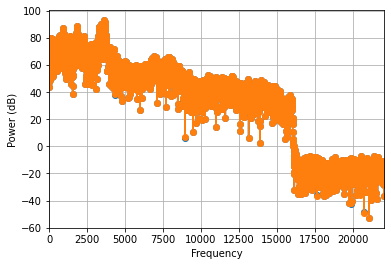

In [260]:
from spectrum import Periodogram, data_cosine

p = Periodogram(clip(3.02,0.1), sampling=s_rate)
p()
p.plot(marker='o')

Graph 19, negative example, just before the whistle.  No peaks like in Graph 18.

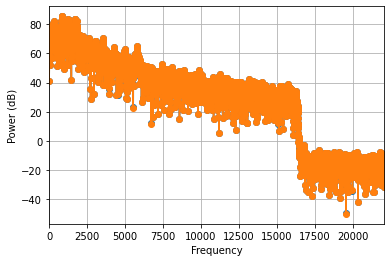

In [261]:
p = Periodogram(clip(2.7,0.1), sampling=s_rate)
p()
p.plot(marker='o')

Graph 20, positive example at the 30s mark. Wow this looks GREAT, lots of peaks espat 3K! Again this looks very similar to Graph 18.

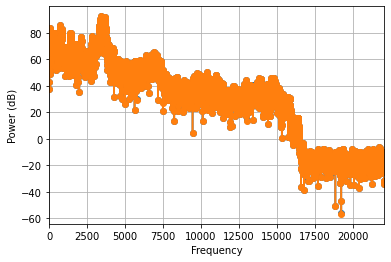

In [262]:
p = Periodogram(clip(30.5,0.1), sampling=s_rate)
p()
p.plot(marker='o')

In [984]:
# Convenience function for building spectrum plots
from spectrum import psd

def pdg(start,end):
    p = Periodogram(clip(start,end), sampling=s_rate) #,NFFT=365)

    #p = psd.FourierSpectrum(clip(start,end), sampling=s_rate,NFFT=365)

    #p()
    p.plot(marker='o')
    return p

Graph 21, negative, loud cheering, no whistle.  Looks different than Graph 20

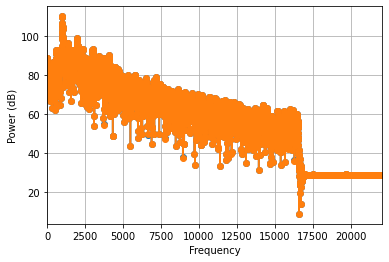

In [400]:
    
p = pdg(48.5,.1)

Graph 22, positive strong peak.  Short clip

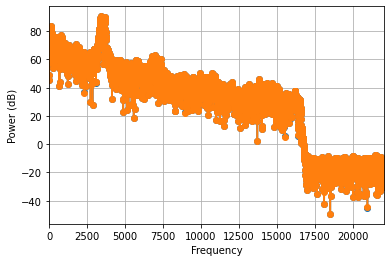

In [310]:
p = pdg(30.4,0.1)

Graph 23, test example of sine wave signal

In [633]:
def pdg2(start,end,NFFT=None):
    from spectrum import tools as stools
    p = Periodogram(np.average(clip(start,end),axis=1), sampling=s_rate, NFFT=NFFT)
    psd = p.psd

    mx = np.max(psd)
    print(mx)
    plt.plot(p.frequencies(),10 * stools.log10(psd/mx))                                                          
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power(db)')
    #plt.xscale('log')

    #plt.yscale('log')

    #print (plt.ylim())
    #plt.ylim(0,40000)

    #plt.xlim(0,10000)

    plt.show()
    return p

 Graph 25, positive


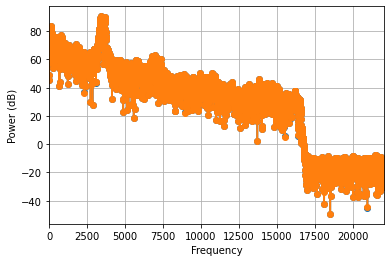

In [604]:
p=pdg(30.4,.1)


Graph 26, positive.  Investigate left side of peak at 3K.  There looked like there may be andditional peaks below 3K from Graph 18.  But this shows no strong peaks below 3K

1156918462.5068138


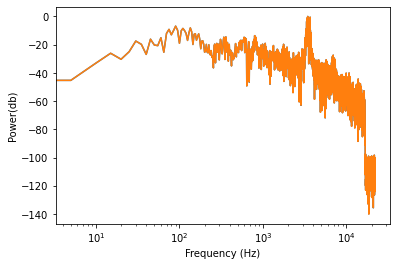

In [399]:
pdg2(30.4,.1)


Graph 27, positvie, longer clip.  Investigate left side of peak at 3K.  There looked like there may be andditional peaks below 3K from Graph 18.  But this shows no strong peaks below 3K

3435587456.0078855


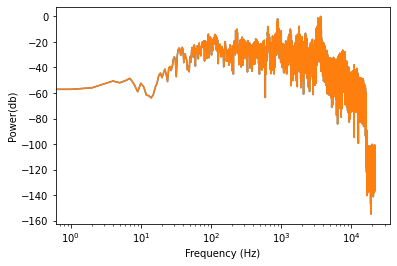

In [455]:
p=pdg2(2.9,.5)


Graph 28, negative, longer clip.  Investigate left side of peak at 3K.  This is clapping noise.  Just before serve.

1116651123.0189195


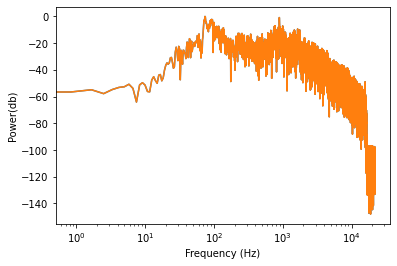

In [396]:
p=pdg2(5,.6)


Graph 29, negative, short clip.  This is chanting noise.

30469611084.960854


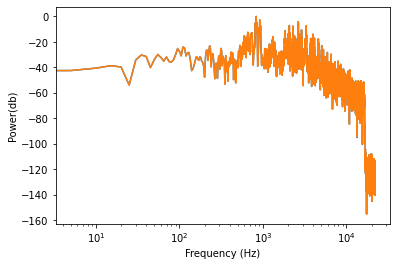

In [395]:
p=pdg2(35,.1)


Graph 30, negative, short clip.  Relatively quiet, Audience member cheering, far from mic, can barely make it out.

932374264.4599414


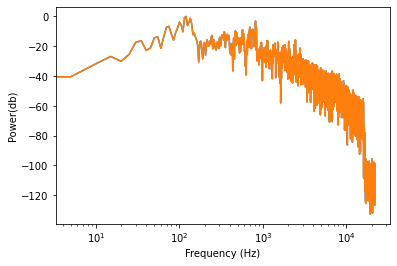

In [393]:
p=pdg2(27,.1)

## Experiment 1
Reducing resolution of FFT by brute force; averaging the dataset.
Turns out this was a bad approach.  Dont do this.  the FFT api has input parameters to control the number of frequency bins

In [401]:
new_psd=np.average(p.psd.reshape(-1,4), axis=1)

ValueError: cannot reshape array of size 8822 into shape (4)

In [402]:
givenArray = np.array([6, 5, 4, 3, 2, 1, 9,
                       8, 7, 12, 11, 10, 15, 
                       14, 13])
  
# here we took 3 as our input
n = 3
  
# calculates the average
avgResult = np.average(givenArray.reshape(-1, n), axis=1)
  
print("Given array:")
print(givenArray)
  
print("Averaging over every ", n, " elements of a numpy array:")
print(avgResult)

Given array:
[ 6  5  4  3  2  1  9  8  7 12 11 10 15 14 13]
Averaging over every  3  elements of a numpy array:
[ 5.  2.  8. 11. 14.]


In [403]:
p.psd

array([[8.22129322e+08, 8.23476267e+08],
       [5.36399422e+08, 5.37117807e+08],
       [7.68111664e+07, 7.67848438e+07],
       ...,
       [7.49558624e+02, 7.49592628e+02],
       [7.78153687e+02, 7.78199111e+02],
       [8.07006035e+02, 8.07035714e+02]])

In [407]:
avgResult.reshape(-1,1)

array([[ 5.],
       [ 2.],
       [ 8.],
       [11.],
       [14.]])

In [408]:
givenArray = np.array([6, 5, 4, 3, 2, 1, 9,
                       8, 7, 12, 11, 10, 15, 
                       14, 13])

In [409]:
b=givenArray.reshape(-1, n)

In [410]:
b

array([[ 6,  5,  4],
       [ 3,  2,  1],
       [ 9,  8,  7],
       [12, 11, 10],
       [15, 14, 13]])

In [411]:
np.average(b,axis=1)

array([ 5.,  2.,  8., 11., 14.])

In [412]:
p.psd

array([[8.22129322e+08, 8.23476267e+08],
       [5.36399422e+08, 5.37117807e+08],
       [7.68111664e+07, 7.67848438e+07],
       ...,
       [7.49558624e+02, 7.49592628e+02],
       [7.78153687e+02, 7.78199111e+02],
       [8.07006035e+02, 8.07035714e+02]])

In [413]:
b=p.psd.copy()

In [414]:
b

array([[8.22129322e+08, 8.23476267e+08],
       [5.36399422e+08, 5.37117807e+08],
       [7.68111664e+07, 7.67848438e+07],
       ...,
       [7.49558624e+02, 7.49592628e+02],
       [7.78153687e+02, 7.78199111e+02],
       [8.07006035e+02, 8.07035714e+02]])

In [415]:
c=np.average(b,axis=1)

In [416]:
c

array([8.22802795e+08, 5.36758615e+08, 7.67980051e+07, ...,
       7.49575626e+02, 7.78176399e+02, 8.07020874e+02])

In [417]:
len(c)

4411

In [418]:
4411/3


1470.3333333333333

In [419]:
4411/7

630.1428571428571

In [420]:
d=c.reshape(-1,3)

ValueError: cannot reshape array of size 4411 into shape (3)

In [428]:
d=np.split(c,[-1,4410])

In [431]:
e=d[0]

f=np.average(e.reshape(-1,3),axis=1)
f

array([4.78786471e+08, 5.19690217e+08, 2.64342593e+08, ...,
       7.65269158e+02, 7.77149969e+02, 7.65827674e+02])

In [432]:
len(f)

1470

In [438]:
g=p.frequencies()
gprime=np.split(g,[-1,4410])
gprime
gdprime=np.average(gprime[0].reshape(-1,3),axis=1)
gdprime

array([5.0000e+00, 2.0000e+01, 3.5000e+01, ..., 2.2010e+04, 2.2025e+04,
       2.2040e+04])

In [439]:
len(gdprime)

1470

In [632]:
def pdg5(psd,frequencies):
    mx = np.max(psd)
    print(mx)
    plt.plot(frequencies,10 * stools.log10(psd/mx))                                                          
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power(db)')
    #plt.xscale('log')

    #plt.yscale('log')

    #print (plt.ylim())
    #plt.ylim(0,40000)

    #plt.xlim(0,10000)

    plt.show()

22049.0


ValueError: x and y must have same first dimension, but have shapes (1470,) and (441,)

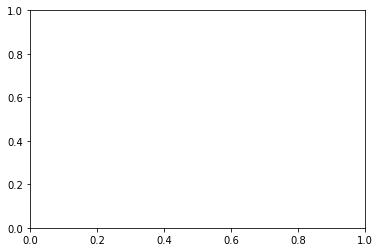

In [449]:
pdg5(f,gdprime)

In [444]:
print(f)

[4.78786471e+08 5.19690217e+08 2.64342593e+08 ... 7.65269158e+02
 7.77149969e+02 7.65827674e+02]


In [445]:
print(gdprime)

[5.0000e+00 2.0000e+01 3.5000e+01 ... 2.2010e+04 2.2025e+04 2.2040e+04]


In [489]:
g=reduce_resolution(np.average(p.psd,axis=1),np.max, 50)

In [490]:
f=reduce_resolution(p.frequencies(),np.max, 50)

Invalid limit will be ignored.
  plt.xlim(0,10000)



3435356788.0833635


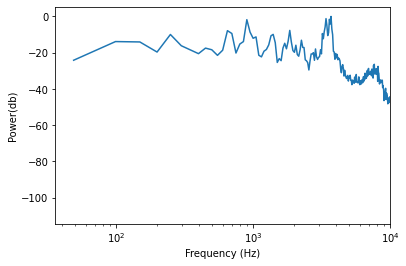

In [502]:
#
# Graph 31
#
pdg5(g,f)

In [492]:
len(g)

441

In [481]:
p.psd

array([[2.89305532e+03, 2.89719244e+03],
       [6.70318614e+03, 6.70691000e+03],
       [8.78711901e+03, 8.79173303e+03],
       ...,
       [9.60529725e-03, 9.60320900e-03],
       [5.60228082e-04, 5.59249483e-04],
       [5.03269603e-04, 5.03908563e-04]])

Invalid limit will be ignored.
  plt.xlim(0,10000)



5454927871.151246


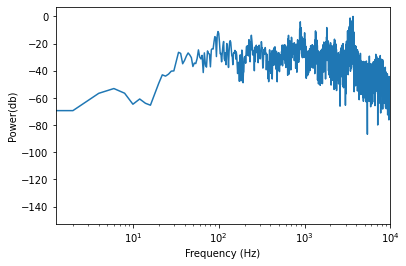

In [500]:
#
# Graph 32
#
p=pdg2(2.9,.5)

Invalid limit will be ignored.
  plt.xlim(0,10000)



5539052296.996991


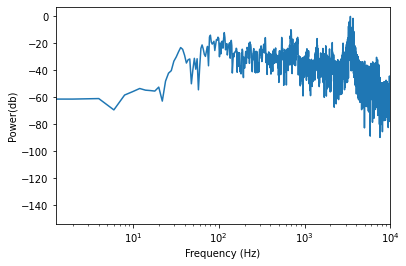

In [503]:
#
# Graph 33
#
p=pdg2(30.4,.5)

In [656]:
def pdgreduce(p,n=50,function=np.max):
    #g=reduce_resolution(p.psd,function, n)
    #f=reduce_resolution(p.frequencies(),function, n)
    #print(f"Reduced from {len(p.psd)} to {len(f)}")
    #pdg5(g,f)
    return p

Invalid limit will be ignored.
  plt.xlim(0,10000)



5539052296.996991


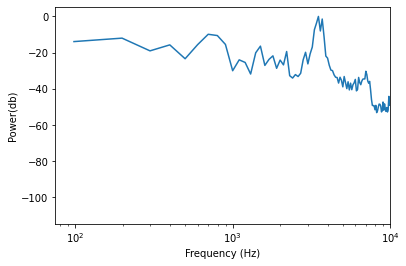

In [557]:
def reduce_resolution(data, function, nelements):
    remainder = len(data) % nelements
    if remainder != 0:
        #raise RuntimeError(f"Need to adjust by {remainder}")
        #print(len(data))
        #print(remainder)
        #splits = np.split(data, [-1,len(data)-remainder])
        #data = splits[0]
        data = np.array(data[np.s_[:(len(data)-remainder)]])
        #data = d
        #print(data)
        #print(len(data))
        #print(len(data)%nelements)
    a = data.reshape(-1,nelements)
    b = function(a,axis=1)
    return b

pdgreduce(p)

Invalid limit will be ignored.
  plt.xlim(0,10000)



496865858.3792272


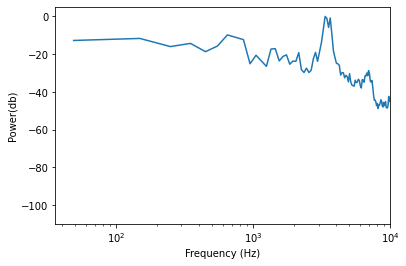

In [558]:
#
# Graph 34
#
pdgreduce(p,function=np.average)

In [525]:
len(p.psd) %50

26

Invalid limit will be ignored.
  plt.xlim(0,10000)



5454927871.151246


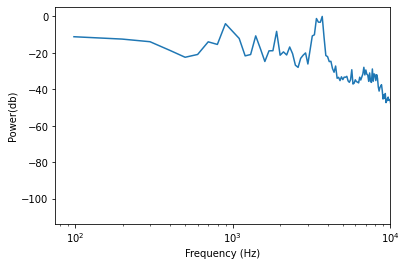

In [560]:
#
# Graph 35
#
pdgreduce(p)

3044545.476926671


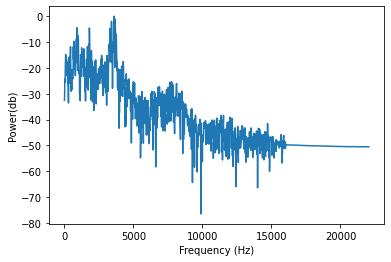

In [658]:
#
# Graph 36
#
p=pdgreduce(pdg2(3.0,.5,NFFT=3000),n=25,function=np.max)

## Experiment 2

Reduce the resolution by change the number of FFT bins.

69.43891616269772


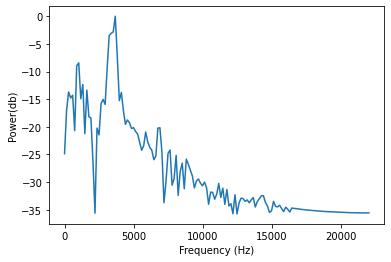

In [689]:
#
# Graph 37, positive, fewer points == fewer features
#
p=pdgreduce(pdg2(3.0,.4,NFFT=300),n=2,function=np.max)

In [ ]:
p.frequencies()

2132516.9823011477


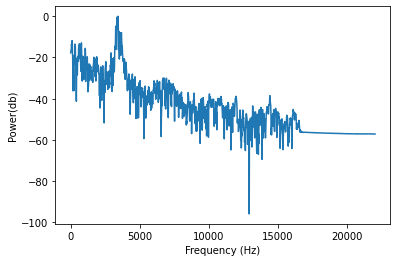

In [686]:
#
# Graph 38, positive, similar to Graph 37 but different point in time.
#
p=pdgreduce(pdg2(30.4,.5,NFFT=3000),n=25,function=np.max)

2.720615745392021


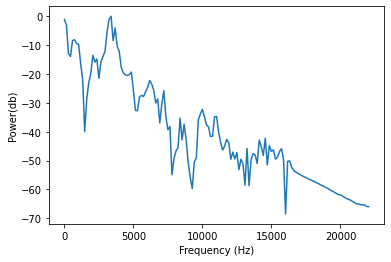

In [687]:
#
# Graph 39, positive, similar to Graph 37 different point in time.
#
p=pdgreduce(pdg2(30.4,.5,NFFT=300),n=2,function=np.max)

In [ ]:
p.frequencies()

916737.1051753117


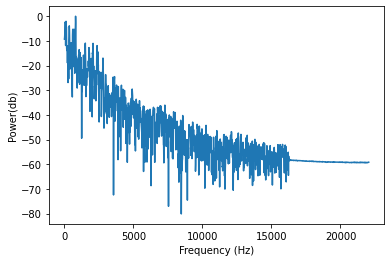

Reduced from 1501 to 60
916737.1051753117


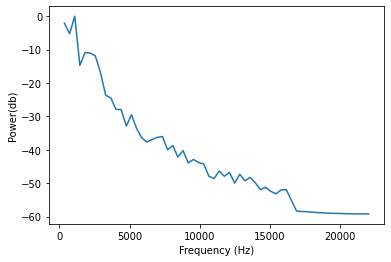

In [648]:
#
# Graph 40 and Graph 41, negative
#
p = pdgreduce(pdg2(27,.5,NFFT=3000),function=np.max,n=25)

4.1790429450921645


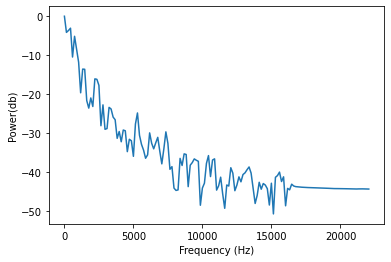

In [691]:
#
# Graph 42, Negative
#
p = pdgreduce(pdg2(27,.5,NFFT=300),function=np.max,n=2)

In [692]:
p.frequencies()[:10]

[0.0, 147.0, 294.0, 441.0, 588.0, 735.0, 882.0, 1029.0, 1176.0, 1323.0]

44035403.50338283


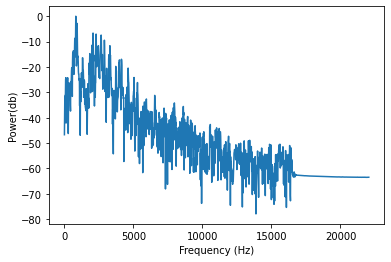

Reduced from 1501 to 60
44035403.50338283


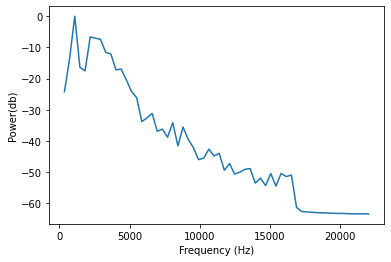

In [644]:
#
# Graph 35 and 36, negative
#
p = pdgreduce(pdg2(35,.5,NFFT=3000),n=25)

44043924859.81887


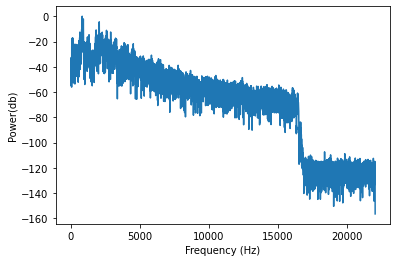

Reduced from 11026 to 441
44043924859.81887


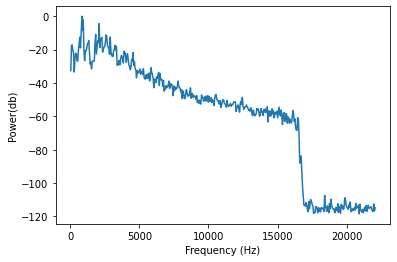

In [641]:
#
# Graph 37 and 38, negative 
#
p = pdgreduce(pdg2(35,.5,NFFT=None),n=25)

In [683]:
len(signal)/s_rate 

372.87

## Experiment 3
Instead of my clip function.  I need code to take audio signal and break it up into frames of arbitrary length.  And sliding frames so that the next frame overlaps the first by an arbitrary amount. There must be something already out there.

Librosa has such functionality.  Plus other interesting capabilities like taking audio signal and splitting out  percussive and  harmonics into separate signals.  

In [693]:

!python -m pip install pygobject

     |████████████████████████████████| 718 kB 2.2 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pycairo-1.21.0-cp39-cp39-macosx_11_0_x86_64.whl
  Created wheel for pygobject: filename=PyGObject-3.42.1-cp39-cp39-macosx_11_0_x86_64.whl size=239240 sha256=bdd84ffc1d64587bfb4858f1773e299842a91dd08765011876e9b143070b1030
  Stored in directory: /Users/alex/Library/Caches/pip/wheels/69/f4/98/952eac3cad4286e40239ddf3088e089fa40efe4966e6ee036b
Successfully built pygobject
You should consider upgrading via the '/Users/alex/Library/PythonVEnvs/vball/bin/python -m pip install --upgrade pip' command.


In [1]:
import librosa

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [481]:
game_audio="5U5A9273.mp3"

y,sr = librosa.load(game_audio)#, offset=2, duration=2)



/Users/alex/Library/PythonVEnvs/vball/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Librosa by default will mix a stereo signal to mono, and cut the sampling rate in half.

In [14]:
y

array([-0.00822371,  0.04156819,  0.11007465, ...,  0.06538866,
        0.0881855 ,  0.12919669], dtype=float32)

In [15]:
sr

22050

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio

import librosa
import librosa.display

In [29]:
rp = np.max(np.abs(D))



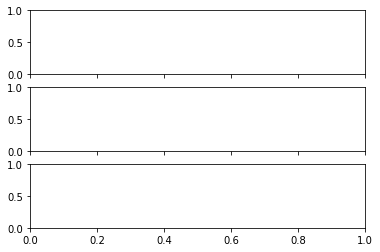

In [26]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)



From audacity app, I can view the spectrograph and pick out the precise times where a whistle begins.  I can record these times in a whistle file, format is `[Minutes:]Seconds[.Milliseconds] [# Comment]`.  The code below reads files in this format, and returns an array of seconds.

In [321]:
from itertools import takewhile
 
 
# stripComments :: [Char] -> String -> String
def stripComments(cs):
    '''The lines of the input text, with any
       comments (defined as starting with one
       of the characters in cs) stripped out.
    '''
    def go(cs):
        return lambda s: ''.join(
            takewhile(lambda c: c not in cs, s)
        ).strip()
    return lambda txt: '\n'.join(map(
        go(cs),
        txt.splitlines()
    ))

def parseMinSec(cs):
    minute = seconds = 0
  
    if ':' in cs:
        left, right = cs.split(":")
        minute = float(left) * 60
        seconds = float(right)
    else:
        seconds = float(cs)

    
    return minute + seconds
        
    

with open("5u5a9273.whistle","r") as f:
    lines = [parseMinSec(stripComments("#")(line.rstrip())) for line in f ]
    
print(lines)

[2.9, 11.3, 30.38, 59.149, 66.49, 82.34, 93.0, 102.483, 111.75800000000001, 121.754, 133.0, 148.374, 175.329, 195.293, 216.68, 226.053, 230.989, 243.919, 272.69, 287.372, 298.841, 308.131, 315.445, 325.448, 334.8, 356.318, 362.906, 370.687]


Testing out logic which converts seconds to frame number.  So that we can covert the seconds above to judgments array using frame # as index into the array.  

In [322]:
import math
math.fabs(np.min(np.subtract(np.multiply(lines,3),10))/3) <= ((1/2) * frame_size_seconds)

True

In [323]:
import math
math.fabs(np.min(np.subtract(np.multiply(lines,3),11))/3) <= ((1/3) * frame_size_seconds)

False

In [871]:
predictions = np.zeros(dtype=float,shape=(len(z)))
np.put(predictions, indices, 1.)

In [196]:
np.put(predictions, indices, 1.)

In [200]:
len(predictions)

1116

In [434]:
np.shape(z)

(1116, 22050)

Testing how to stack Judgements to Input features to build a training set.  In this case we have 2 feature vectors stacked with 2 jugements.  To create a single matrix with last column as judgments.

In [217]:
bb=np.column_stack((np.array([[1,2,3],[10,20,30]]),np.array([0,1])))

In [218]:
bb

array([[ 1,  2,  3,  0],
       [10, 20, 30,  1]])

Testing logic to do band pass filter on signal

In [220]:
from scipy import signal

b, a = signal.iirfilter(17, [2000, 7900], rs=60,fs=sr,
                         btype='band', analog=False, ftype='cheby2')
y_f =signal.lfilter(b,a,y,axis=-1)



Testing logic to create frames of audio from audio signal based on frame_length, and sliding based on hop_length

In [771]:
frame_size_seconds=0.7
frame_length=frame_size_seconds * sr
hop_in_window_divisions = 2
hop_length=frame_size_seconds / hop_in_window_divisions * sr
frame_length_c=math.ceil(frame_length)
frame_length= frame_length_c
hop_length=math.floor(frame_length_c / hop_in_window_divisions)

print(f"hop_length={hop_length} frame_length={frame_length}")

#zz=librosa.util.frame(y_f,
#                   frame_length=22050,
#                   hop_length=7350,
#                   axis=0,
#                   writeable=False,
#                   subok=False)

z=librosa.util.frame(y_f,
                   frame_length=frame_length_c,
                   hop_length=math.floor(frame_length_c / hop_in_window_divisions),
                   axis=0,
                   writeable=False,
                   subok=False)




hop_length=7717 frame_length=15435


Logic to convert judgment in seconds to frames, taking into account sliding frames

In [772]:

def matching_frames(feature_start_instances=[],hop_fraction=3, feature_duration_secs=1.43, feature_frame_overlap=.5):
    for i in feature_start_instances:
        a = i*hop_fraction -1
        b = feature_duration_secs * feature_frame_overlap
        b = feature_duration_secs * feature_frame_overlap

        yield iter(range(math.floor(a-b),math.ceil(a+b+1)))
        
        
def convert_judgement_in_seconds_to_frames(hop_length, judgements=[]): # frame_size,
    for i in judgements:
#        r = i * sr % frame_size  # sec * samples / sec % ( samples / frame ) = frame
        a = i * sr / hop_length # sec * samples / sec / ( samples / frame ) = frame
        a = math.floor(a)
        yield iter(range(a,a+2))



indices=[item for i in convert_judgement_in_seconds_to_frames(judgements=[0.5,0.8,2.9],hop_length=hop_length) for item in i]
#indices = [item for i in matching_frames(lines,feature_frame_overlap=1/3) for item in i]

set(indices)

{1, 2, 3, 8, 9}

In [773]:
indices=[item for i in convert_judgement_in_seconds_to_frames(judgements=lines,hop_length=hop_length) for item in i]

list(islice(indices,0,5))


[8, 9, 32, 33, 86]

In [776]:
len(z)

1064

In [775]:
len(z[0])

15435

In [255]:
Audio(data=y_f,rate=sr)

## Spectro 3 

Here we plot an audio clip that has been filter to do bandpass between 2-7.9K.  Note the black areas, they've been filtered out.  

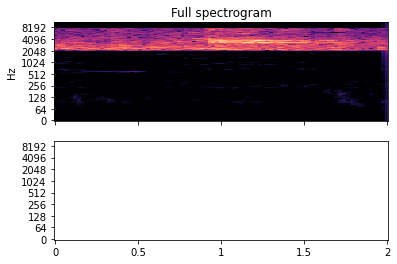

In [256]:
D = librosa.stft(y_f)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=rp),
                         y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Full spectrogram')
ax[0].label_outer()

In [271]:
np.angle(D)[0]
librosa.fft_frequencies()[750]

8074.951171875

In [75]:
3.5*sr

77175.0

In [76]:
3.5*3

10.5

In [483]:
z[10]
len(z)

1116

In [78]:
z[8]

array([ 0.01732441,  0.02362795,  0.01136784, ..., -0.04728118,
       -0.00956917,  0.01807188])

In [151]:
Audio(data=z[6],rate=sr)

In [91]:
2.9*3

8.7

In [313]:
frame_length / 3
len(y)
len(y) / 6 /512

14.35546875

In [431]:

#y_fft = librosa.stft(y, n_fft=512, center=False,win_length=512*4,hop_length=None)#len(y)/16)

y_fft = librosa.stft(y_f,n_fft=6144,center=False,hop_length=25000)#512*14)# * 16)



In [710]:

#y_fft = librosa.stft(y, n_fft=512, center=False,win_length=512*4,hop_length=None)#len(y)/16)

def window_fft(y,n_fft=2048,hop_length=12000):
    return librosa.stft(y,n_fft=n_fft,center=False,hop_length=hop_length)

y_fft2 = librosa.stft(z[177],n_fft=6144,center=False,hop_length=1)#25000)#512*14)# * 16)



In [439]:
np.shape(y_fft2)

(3073, 11)

In [396]:
y_fft[2]

array([-2.49715115e-06-1.80915831e-06j, -7.74635114e-07-9.73669693e-07j,
        5.12340863e-06-3.59153604e-06j,  7.48955946e-06+1.42633594e-05j,
        6.49043247e-06+9.59241309e-07j,  8.97900008e-07-4.15887363e-06j,
        4.49671054e-06-8.65714390e-06j])

In [373]:
np.shape(y_fft[1024])

(5,)

Spectro 4, positive example, whistle peaks evident in yellow.  Using librosa to plot the spectrogram.

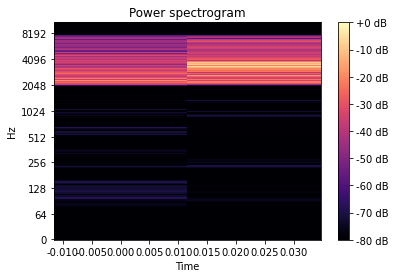

In [442]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(y_fft,
                                                      ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [711]:
def show_spectrogram(yy,n_fft=nfft,msg=None,hop_length=12000):
    import matplotlib.pyplot as plt
    yyy = window_fft(yy,n_fft,hop_length=hop_length)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(yyy,
                                                      ref=np.max),
                               y_axis='log', x_axis='time', ax=ax,fmin=1024,fmax=8192)
    ax.set_title(f'Power spectrogram {msg}' if msg else 'Power spectrogram' )
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    return yyy

In [495]:
np.shape(z[1111])

(22050,)

In [413]:
len(y_f)/2/3/512
sr

22050

In [472]:
np.shape(y_fft2)

(3073, 11)

The logic compute the array indices in the fft output when bound the frequencies specified by low and high.

In [815]:
#nfft=256
def find_bounds(n_fft=2048,sr=sr,low=2000,high=4000,ts=3):
    freq=librosa.fft_frequencies(sr=sr,n_fft=n_fft)
    low_= None
    high_=None
    j=0
    for i in freq:

        if low_ is None:
            if i > low:
                low_ = j
        if low_ and high_ is None:
            if i > high:
                high_ = j-1
        j=j+1

    print(f"low={low_} - hi={high_} x {ts} cross {(high_-low_)*ts} fft bins {len(freq)}")
    return (low_,high_)

def find_bounds_bands(n_fft=nfft,ts=3):
    return (find_bounds(n_fft, low=2000,high=4096,ts=ts),
    find_bounds(n_fft, high=8000,low=6000,ts=ts))

Here we find that 

index 47 is the low and index 95 is high for 2000 and 4096 HZ
index 140 is the low and index 185 is high for 6000 and 8000 HZ

Using the fft with this configuration of n_fft yields 95 features / frame to capture 2000 - 4096HZ

In [816]:
((low_1,high_1),(low_2,high_2))=find_bounds_bands(n_fft=nfft)


low=47 - hi=95 x 3 cross 144 fft bins 257
low=140 - hi=185 x 3 cross 135 fft bins 257


## Experiment 4

Spectro 5
Spectro 6
Spectro 7
Spectro 8
Spectro 9
Spectro 10

Positive / Negative example noted in title of image.  

Here we are using librosa frames to store the audio clips.
The audio frames are pass to FFT transformation.  This outputs a new set of frames containing FFTs.   These FFT frames are sliced to extract the frequency bins of interest 2-4K.  Giving us our input features.
The whistle file is loaded and converted to jugments and stacked with the features and save to disk in preparation for training pipeline.


low=47 - hi=95 x 2 cross 96 fft bins 257
low=140 - hi=185 x 2 cross 90 fft bins 257


(257, 2)

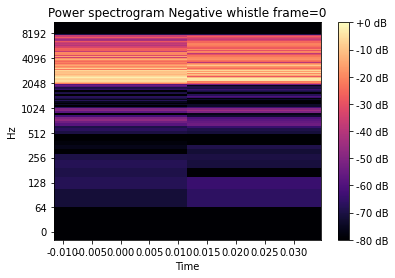

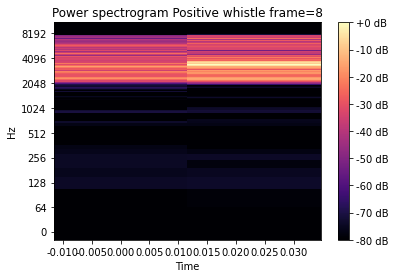

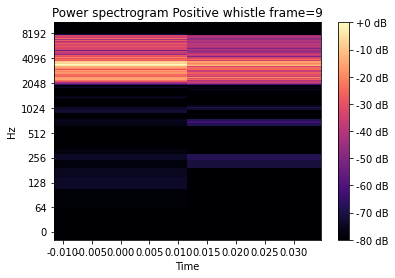

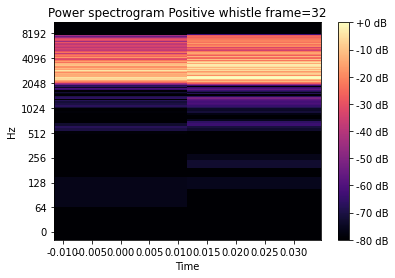

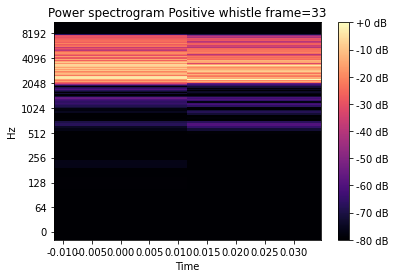

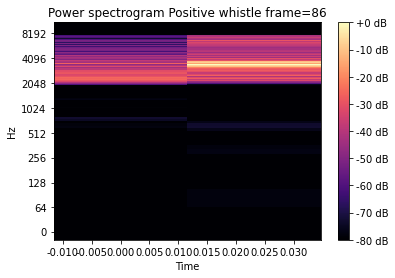

In [882]:
from itertools import islice

nfft=512
hop_length=math.ceil(frame_length_c/2)
def ss(ar,index,n_fft,positive_example=True):
    return show_spectrogram(ar[index],n_fft=n_fft,msg=f"Positive whistle frame={index}" if positive_example else f"Negative whistle frame={index}",hop_length=hop_length)
    
ss(z,0,nfft,False)
for i in islice(indices,0,5,None):
    kk=ss(z,i,nfft,True)
#kk=ss(z,1111,nfft,True)

((low_1,high_1),(low_2,high_2))=find_bounds_bands(n_fft=nfft,ts=np.shape(kk)[1])
np.shape(kk)

In [802]:
np.abs(kk[47])

array([0.06519041, 0.01625264])

In [803]:
np.abs(kk[92])

array([0.11614453, 0.26306985])

In [852]:
dbs=np.concatenate(np.abs(np.take(kk,range(low_1,high_1),axis=0)))

In [853]:
np.sum(np.subtract(dbs,np.abs(np.array(kk)[np.s_[low_1:high_1]])))
             

0.0

In [831]:
ff=np.take(librosa.fft_frequencies(sr=sr,n_fft=nfft),range(low_1,high_1))

In [861]:
np.concatenate((dbs,ff),axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [848]:
np.abs(kk[np.s_[low_1:high_1]])

array([[0.06519041],
       [0.14500732],
       [0.36888687],
       [0.14111948],
       [0.60639127],
       [0.87079617],
       [0.89808557],
       [0.75646667],
       [0.85468566],
       [0.75078876],
       [0.52617571],
       [0.40866681],
       [0.40558511],
       [0.37440883],
       [0.43344728],
       [0.57800086],
       [0.12267666],
       [0.56407424],
       [0.45100286],
       [0.38024208],
       [0.42536108],
       [0.41204685],
       [0.17713634],
       [0.18897363],
       [0.17569864],
       [0.08783357],
       [0.10173543],
       [0.17506781],
       [0.39040052],
       [0.28517972],
       [0.14192576],
       [0.04303662],
       [0.07436823],
       [0.2797192 ],
       [0.8028193 ],
       [0.76220352],
       [0.15967163],
       [0.10753587],
       [0.10434623],
       [0.13747116],
       [0.06489369],
       [0.20918294],
       [0.1986577 ],
       [0.03703351],
       [0.05150236],
       [0.11614453],
       [0.05516516],
       [0.104

In [855]:
np.shape(dbs)

(48,)

In [851]:
np.shape(np.concatenate(dbs,axis=None))

(48,)

In [856]:
dbs

array([0.06519041, 0.14500732, 0.36888687, 0.14111948, 0.60639127,
       0.87079617, 0.89808557, 0.75646667, 0.85468566, 0.75078876,
       0.52617571, 0.40866681, 0.40558511, 0.37440883, 0.43344728,
       0.57800086, 0.12267666, 0.56407424, 0.45100286, 0.38024208,
       0.42536108, 0.41204685, 0.17713634, 0.18897363, 0.17569864,
       0.08783357, 0.10173543, 0.17506781, 0.39040052, 0.28517972,
       0.14192576, 0.04303662, 0.07436823, 0.2797192 , 0.8028193 ,
       0.76220352, 0.15967163, 0.10753587, 0.10434623, 0.13747116,
       0.06489369, 0.20918294, 0.1986577 , 0.03703351, 0.05150236,
       0.11614453, 0.05516516, 0.10435372])

In [857]:
ff

array([2024.12109375, 2067.1875    , 2110.25390625, 2153.3203125 ,
       2196.38671875, 2239.453125  , 2282.51953125, 2325.5859375 ,
       2368.65234375, 2411.71875   , 2454.78515625, 2497.8515625 ,
       2540.91796875, 2583.984375  , 2627.05078125, 2670.1171875 ,
       2713.18359375, 2756.25      , 2799.31640625, 2842.3828125 ,
       2885.44921875, 2928.515625  , 2971.58203125, 3014.6484375 ,
       3057.71484375, 3100.78125   , 3143.84765625, 3186.9140625 ,
       3229.98046875, 3273.046875  , 3316.11328125, 3359.1796875 ,
       3402.24609375, 3445.3125    , 3488.37890625, 3531.4453125 ,
       3574.51171875, 3617.578125  , 3660.64453125, 3703.7109375 ,
       3746.77734375, 3789.84375   , 3832.91015625, 3875.9765625 ,
       3919.04296875, 3962.109375  , 4005.17578125, 4048.2421875 ])

In [869]:
t_sample=np.column_stack((dbs,ff))

In [870]:
np.shape(t_sample)

(48, 2)

In [872]:
predictions = np.zeros(dtype=float,shape=(len(z)))
np.put(predictions, indices, 1.)

In [881]:
len(predictions)
predictions[32]

1.0

In [887]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
np.vstack((np.vstack((a,b)),b))

array([[1, 2, 3],
       [4, 5, 6],
       [4, 5, 6]])

In [903]:
from itertools import islice

nfft=512
hop_length=math.ceil(frame_length_c)
def sss(ar,index,n_fft,positive_example=True):
    return window_fft(ar[index],n_fft=nfft,hop_length=hop_length)


acc=None
for i in range(len(z)): # islice(indices,0,5,None):
    kk=sss(z,i,nfft,True)
    kk=np.concatenate(np.abs(np.array(kk)[np.s_[low_1:high_1]]))
    if acc is not None:
        acc=np.vstack((acc,kk)) #kk),axis=0)
    else:
        acc=kk
        
#kk=ss(z,1111,nfft,True)
kk=acc
#((low_1,high_1),(low_2,high_2))=find_bounds_bands(n_fft=nfft,ts=np.shape(kk)[1])

np.shape(kk)

(1064, 48)

In [904]:
len(predictions)

1064

In [905]:
kk[8]


array([0.0167679 , 0.06556171, 0.36373688, 0.64948222, 0.34670801,
       0.77855261, 0.99383156, 1.75073022, 1.28199558, 0.65601059,
       0.48399661, 0.46064241, 0.25225779, 0.46325622, 0.72283028,
       0.56972733, 0.61473266, 1.01619512, 1.25199509, 0.86757375,
       0.23934777, 0.54501933, 0.60300699, 0.47629111, 0.51748967,
       0.42643468, 1.08836059, 1.92278475, 2.22553201, 0.93130304,
       0.84853519, 0.53328083, 0.37552281, 0.7792951 , 0.54162808,
       1.05369642, 0.80146031, 0.30840067, 0.64743287, 0.2813034 ,
       0.16946351, 0.16719805, 0.25051501, 0.31170852, 0.30914187,
       0.26155272, 0.4812359 , 0.32148094])

In [906]:
kk[5]

array([0.01551134, 0.27217956, 0.55377751, 0.37206906, 0.40282813,
       0.38377931, 0.87679822, 1.76524928, 2.49698939, 0.85348303,
       1.04912144, 1.1338947 , 0.67056306, 0.28096861, 0.36257768,
       0.82461911, 0.82515224, 0.62516832, 0.63084658, 0.28917697,
       0.36888479, 0.40012396, 0.56465322, 0.75722118, 0.59018095,
       0.29312639, 0.64809526, 0.67611203, 0.70306756, 0.66589545,
       0.44741712, 0.02947087, 0.3836495 , 0.52723441, 0.43774444,
       0.61966537, 0.49252625, 0.58932323, 0.81982863, 0.44256543,
       0.19293326, 0.217305  , 0.34296413, 0.54734265, 0.22333033,
       0.18873161, 0.32049756, 0.40432169])

In [907]:
predictions[8]

1.0

In [908]:
predictions[5]

0.0

In [909]:
kkk=np.column_stack((kk,predictions))

Here we verify the last item is y value

In [910]:
kkk[8]

array([0.0167679 , 0.06556171, 0.36373688, 0.64948222, 0.34670801,
       0.77855261, 0.99383156, 1.75073022, 1.28199558, 0.65601059,
       0.48399661, 0.46064241, 0.25225779, 0.46325622, 0.72283028,
       0.56972733, 0.61473266, 1.01619512, 1.25199509, 0.86757375,
       0.23934777, 0.54501933, 0.60300699, 0.47629111, 0.51748967,
       0.42643468, 1.08836059, 1.92278475, 2.22553201, 0.93130304,
       0.84853519, 0.53328083, 0.37552281, 0.7792951 , 0.54162808,
       1.05369642, 0.80146031, 0.30840067, 0.64743287, 0.2813034 ,
       0.16946351, 0.16719805, 0.25051501, 0.31170852, 0.30914187,
       0.26155272, 0.4812359 , 0.32148094, 1.        ])

In [911]:
np.shape(kk)

(1064, 48)

In [912]:
np.save("training_set_1.npy",kkk,allow_pickle=False)

In [915]:
kkkk= np.load("training_set_1.npy")

In [917]:
np.sum(np.subtract(kkk,kkkk))

0.0

In [918]:
np.shape(kkkk)

(1064, 49)

In [919]:
np.shape(kkk)

(1064, 49)

In [920]:
np.sum(predictions)

56.0

In [922]:
len(predictions)

1064

In [923]:
np.shape(kkk)

(1064, 49)